# ConvNet Weights Initialization

In this notebook, we will create and save locally the weights of a simple Convolutional Neural Network (ConvNet) designed for the MNIST handwritten digit dataset.

### Dataset Overview

The MNIST dataset is a benchmark dataset consistsing of:

- **Features**:  
  $28 * 28$ grayscale images of handwritten digits, with $60,000$ training samples and $10,000$ test samples.
    
- **Labels**:  
  The target variable representing the digit in the image, which can take one of the following values:  
  $ \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\} $.
    

The dataset is publicly available and can be downloaded from the [MNIST dataset page](http://yann.lecun.com/exdb/mnist/) or other sources. In this notebook we will pull it using the `torchvision` library.

### ConvNet Architecture

The ConvNet is designed to be as simple as possible, ensuring efficiency and compatibility with hardware synthesis using **Vitis HLS**. The architecture includes:

1. **Convolutional Layer**:
   - **Conv1**: $3$ filters of size $3 \times 3$, stride $1$, and padding $1$.
   - This layers uses the **ReLU** activation function.

2. **Pooling Layer**:
   - Max pooling layer with a kernel size of $2 \times 2$ and stride $2$, reducing the spatial dimensions by half.

3. **Fully Connected Layer**:
   - **Output Layer (FC2)**: Fully connected layer with $10$ neurons, corresponding to the ten digit classes (0–9). This layer does not apply an activation function, as it is followed by the softmax during training or inference.

---

Let's start by downloading the dataset using `torchvision`

In [1]:
import torchvision

dataset = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)

test_dataset = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,))
    ])
)

We can now proceed by defining the ConvNet class, which will inherit from PyTorch's `nn.Module`.

In [2]:
import torch
import torch.nn as nn

# check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # x = [1, 28, 28]
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1)  # 5 filters of size 3x3, formula is (W−F+2P)/S+1
        # x = [3, 28, 28]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling, formula is (W−F)/S+1
        # x = [3, 14, 14]
        self.fc1 = nn.Linear(3 * 14 * 14, 10)  # Flatten the output
       
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x


Using device: cuda


In [3]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split


# Set random seed for reproducibility
torch.manual_seed(4242)

# hyperparameters
batch_size = 64
NUM_EPOCHS = 100
learning_rate = 0.001

# split dataset into training and validation sets (70% train, 30% val)
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

# initialize network, loss function and optimizer
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Number of parameters in the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * train_correct / train_total

    # validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():  # disable gradient calculations
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * val_correct / val_total

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_accuracy:.2f}%")

# test phase
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * test_correct / test_total
print(f"Final Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

Training samples: 42000, Validation samples: 18000, Test samples: 10000
Number of parameters in the model: 5920
Epoch [10/100], Train Loss: 0.1194, Train Acc: 96.49%, Val Loss: 0.1360, Val Acc: 96.03%
Epoch [20/100], Train Loss: 0.0907, Train Acc: 97.30%, Val Loss: 0.1232, Val Acc: 96.38%
Epoch [30/100], Train Loss: 0.0735, Train Acc: 97.74%, Val Loss: 0.1130, Val Acc: 96.77%
Epoch [40/100], Train Loss: 0.0636, Train Acc: 98.03%, Val Loss: 0.1122, Val Acc: 96.79%
Epoch [50/100], Train Loss: 0.0571, Train Acc: 98.27%, Val Loss: 0.1147, Val Acc: 96.75%
Epoch [60/100], Train Loss: 0.0521, Train Acc: 98.34%, Val Loss: 0.1147, Val Acc: 96.88%
Epoch [70/100], Train Loss: 0.0491, Train Acc: 98.39%, Val Loss: 0.1259, Val Acc: 96.73%
Epoch [80/100], Train Loss: 0.0459, Train Acc: 98.53%, Val Loss: 0.1285, Val Acc: 96.69%
Epoch [90/100], Train Loss: 0.0439, Train Acc: 98.55%, Val Loss: 0.1342, Val Acc: 96.61%
Epoch [100/100], Train Loss: 0.0411, Train Acc: 98.71%, Val Loss: 0.1325, Val Acc: 96.7

First, extract the weights of the model:

In [4]:
weights = {}
total_params = 0
for name, param in model.to("cpu").named_parameters():
    weights[name] = param.detach().numpy()
    layer_params = param.numel()
    total_params += layer_params
    print(f"{name}: {param.shape}, Total Parameters: {layer_params}")

print(f"Total Parameters in the model: {total_params}")

conv1.weight: torch.Size([3, 1, 3, 3]), Total Parameters: 27
conv1.bias: torch.Size([3]), Total Parameters: 3
fc1.weight: torch.Size([10, 588]), Total Parameters: 5880
fc1.bias: torch.Size([10]), Total Parameters: 10
Total Parameters in the model: 5920


Finally, save them to a txt file:

In [5]:
# write weights and biases to a file
with open('./convnet_weights.txt', 'w') as f:
    for name, weight in weights.items():
        f.write(f"{name}, shape: {weight.shape}\n")
        if weight.ndim > 2:  # Reshape weights with dimensions > 2 to 2D
            weight = weight.reshape(weight.shape[0], -1)
        if weight.ndim == 1:  # If bias or 1D weights, write on one line separated by commas
            f.write("{")
            f.write(",".join(map(str, weight)) + "},\n")
        else:  # For other weights, save as rows in the file
            for row in weight:
                f.write("{")
                f.write(",".join(map(str, row)) + "},\n")

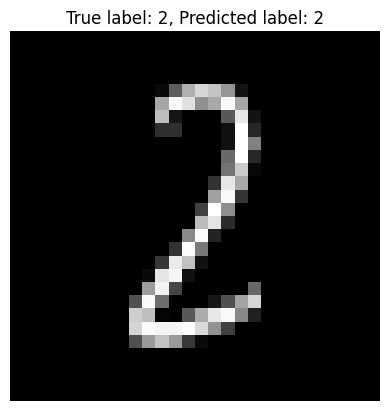

In [14]:
# make the model classify a random image
import matplotlib.pyplot as plt
import numpy as np

# set seed for reproducibility
np.random.seed(3004)

# get a random image from the test set
image, label = test_dataset[np.random.randint(len(test_dataset))]
image = image.unsqueeze(0).to(device)
label = torch.tensor([label]).to(device)

# save the image values to a file
with open('./input_image.txt', 'w') as f:
    f.write(f"Label: {label.item()}\n")
    for row in image.squeeze().cpu().numpy():
        f.write("{")
        f.write(",".join(map(str, row)) + "},\n")

# ensure the model is on the same device as the input
model.to(device)

# get the model's prediction
model.eval()
output = model(image)
_, predicted = output.max(1)

# display the image and the model's prediction
plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
plt.title(f"True label: {label.item()}, Predicted label: {predicted.item()}")
plt.axis('off')
plt.show()